In [1]:
# coding: utf-8
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import exposure
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K, regularizers 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold


2022-09-10 16:45:57.152561: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:

img_files = next(os.walk(r"/home/weiweili/notebook/WHJ/images2/image"))[2]
msk_files = next(os.walk(r"/home/weiweili/notebook/WHJ/images2/lable"))[2]
img_files.sort()
msk_files.sort()
print(len(img_files))
print(len(msk_files))
X = []
Y = []
for img_fl in tqdm(img_files):
    if (img_fl.split('.')[-1] == 'png'):
        img = cv2.imread('/home/weiweili/notebook/WHJ/images2/image/{}'.format(img_fl))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img, (256, 192), interpolation=cv2.INTER_CUBIC)
        X.append(resized_img)

        msk = cv2.imread('/home/weiweili/notebook/WHJ/images2/lable/{}'.format(img_fl.split('.')[0] + '.png'), cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk, (256, 192), interpolation=cv2.INTER_CUBIC)
        Y.append(resized_msk)
print(len(X))
print(len(Y))

 40%|████████████████████████████████████████████▉                                                                    | 35/88 [00:00<00:00, 347.57it/s]

88
88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 329.49it/s]

88
88


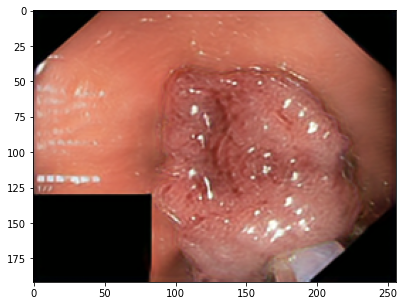

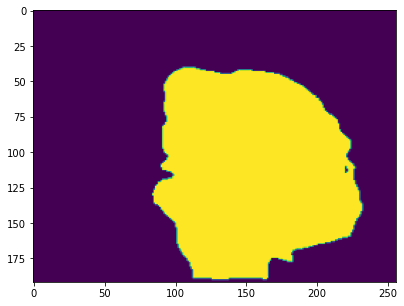

In [4]:
plt.figure(figsize=(10, 5))
plt.imshow(resized_img)
plt.figure(figsize=(10, 5))
plt.imshow(resized_msk)

In [5]:
X = np.array(X)
Y = np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], 1))
X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255
Y_train = np.round(Y_train, 0)
Y_test = np.round(Y_test, 0)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(70, 192, 256, 3)
(70, 192, 256, 1)
(18, 192, 256, 3)
(18, 192, 256, 1)


In [6]:
X_test1 = exposure.adjust_gamma(X_test, 1.5)
X_train1 = exposure.adjust_gamma(X_train, 1.5)


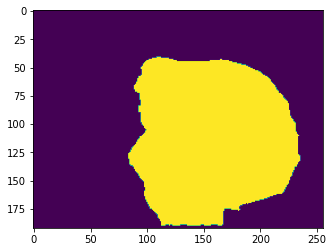

In [7]:
plt.imshow(np.array(X_train[0] * 255, np.uint8))
plt.imshow(np.array(Y_train[0][:, :, 0] * 255, np.uint8))
plt.imshow(np.array(X_test[0] * 255, np.uint8))
plt.imshow(np.array(Y_test[0][:, :, 0] * 255, np.uint8))


In [8]:
#MDE
def get_kernel():


    k1 = np.array([[1,-3, 1],
                   [-3,  8, -3],
                   [1, -3, 1]])
    
    # Sharpening Spatial Kernel, used in paper
    k2 = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
    
    k3 = np.array([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])
    
    return k1, k2, k3



In [9]:
def build_MDE_blocks(layer):

    # Get number of channels in the feature
    in_channels = layer.shape[-1]
    # Get kernel
    _, w, _ = get_kernel()
    # Change dimension
    w = np.expand_dims(w, axis=-1)
    # Repeat filter by in_channels times to get (H, W, in_channels)
    w = np.repeat(w, in_channels, axis=-1)
    # Expand dimension
    w = np.expand_dims(w, axis=-1)
    return w


In [10]:

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


In [11]:
def Net(img_size, num_classes):

    # Kernel size for MDE blocks
    kernel_size = 3
    inputs = Input(img_size)

    # conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    # conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #
    # conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    # conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    # pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #
    # conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    # conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #
    # conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    # conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    # pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    start_neurons = 32

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 1, pool0)

    pool1 = MaxPooling2D((2, 2))(conv2)
    conv3 = DenseBlock(start_neurons * 2, pool1)

    pool2 = MaxPooling2D((2, 2))(conv3)
    conv4 = DenseBlock(start_neurons * 4, pool2)

    pool3 = MaxPooling2D((2, 2))(conv4)
    conv5 = DenseBlock(start_neurons * 8, pool3)

    

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

   

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)


    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

   

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # for multi-class segmentation, use the 'softmax' activation
    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


In [12]:
# custom metrics
smooth = 1


def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection / union


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [13]:
# modole callback
checkpointer = ModelCheckpoint("densenet_unet_model.h5", verbose=0, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-8, mode='min')


In [14]:
# Build model
model = Net((192, 256, 3), 1)
model.summary()


2022-09-10 16:45:59.621097: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-10 16:45:59.632367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d9:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-10 16:45:59.632398: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-09-10 16:45:59.633878: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-09-10 16:45:59.635777: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-09-10 16:45:59.636026: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[jacard, dice_coef])


In [16]:
# Train
epochs = 100
his = model.fit(X_train, Y_train,
          batch_size=2,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)


Epoch 1/100


2022-09-10 16:46:04.369082: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-09-10 16:46:05.540842: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


35/35 [==============================] - 2s 51ms/step - loss: 0.4360 - jacard: 0.1830 - dice_coef: 0.3055 - val_loss: 0.6150 - val_jacard: 0.1746 - val_dice_coef: 0.2948
Epoch 2/100
35/35 [==============================] - 1s 35ms/step - loss: 0.3619 - jacard: 0.2493 - dice_coef: 0.3902 - val_loss: 0.4966 - val_jacard: 0.1535 - val_dice_coef: 0.2646
Epoch 3/100
35/35 [==============================] - 1s 26ms/step - loss: 0.3377 - jacard: 0.2713 - dice_coef: 0.4196 - val_loss: 0.9028 - val_jacard: 0.0258 - val_dice_coef: 0.0502
Epoch 4/100
35/35 [==============================] - 1s 27ms/step - loss: 0.3226 - jacard: 0.3163 - dice_coef: 0.4691 - val_loss: 0.6255 - val_jacard: 0.0712 - val_dice_coef: 0.1328
Epoch 5/100
35/35 [==============================] - 1s 27ms/step - loss: 0.3202 - jacard: 0.3156 - dice_coef: 0.4738 - val_loss: 0.9149 - val_jacard: 0.0299 - val_dice_coef: 0.0580
Epoch 6/100
35/35 [==============================] - 1s 27ms/step - loss: 0.2691 - jacard: 0.3909 - di

Epoch 45/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0346 - jacard: 0.8750 - dice_coef: 0.9324 - val_loss: 0.1100 - val_jacard: 0.8089 - val_dice_coef: 0.8883
Epoch 46/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0328 - jacard: 0.8928 - dice_coef: 0.9427 - val_loss: 0.0755 - val_jacard: 0.8349 - val_dice_coef: 0.9069
Epoch 47/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0312 - jacard: 0.8957 - dice_coef: 0.9447 - val_loss: 0.0693 - val_jacard: 0.8414 - val_dice_coef: 0.9111
Epoch 48/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0278 - jacard: 0.9056 - dice_coef: 0.9500 - val_loss: 0.0820 - val_jacard: 0.8337 - val_dice_coef: 0.9063
Epoch 49/100
35/35 [==============================] - 1s 36ms/step - loss: 0.0273 - jacard: 0.9073 - dice_coef: 0.9512 - val_loss: 0.0644 - val_jacard: 0.8536 - val_dice_coef: 0.9192
Epoch 50/100
35/35 [==============================] - 1s 36ms/step - loss: 0.0283 - j

Epoch 87/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0176 - jacard: 0.9390 - dice_coef: 0.9685 - val_loss: 0.0606 - val_jacard: 0.8819 - val_dice_coef: 0.9362
Epoch 88/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0178 - jacard: 0.9389 - dice_coef: 0.9684 - val_loss: 0.0595 - val_jacard: 0.8836 - val_dice_coef: 0.9372
Epoch 89/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0177 - jacard: 0.9399 - dice_coef: 0.9689 - val_loss: 0.0578 - val_jacard: 0.8853 - val_dice_coef: 0.9382
Epoch 90/100
35/35 [==============================] - 1s 28ms/step - loss: 0.0171 - jacard: 0.9400 - dice_coef: 0.9690 - val_loss: 0.0588 - val_jacard: 0.8841 - val_dice_coef: 0.9375
Epoch 91/100
34/35 [============================>.] - ETA: 0s - loss: 0.0179 - jacard: 0.9383 - dice_coef: 0.9680
Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
35/35 [==============================] - 1s 26ms/step - loss: 0.0178 - jac

In [17]:
history = his.history
loss = history['loss']
jacard = history['jacard']
dice_coef = history['dice_coef']
val_loss = history['val_loss']
val_jacard = history['val_jacard']
val_dice_coef = history['val_dice_coef']

In [18]:
df = pd.DataFrame(history)
df.to_csv('/home/weiweili/notebook/WHJ/params2/densenet_unet_histtory.csv')


In [19]:
# Evaluatete
# Evaluate trained model using Jaccard and Dice metric
yp = model.predict(x=X_test, batch_size=2, verbose=0)
# Round off boolean masks
yp = np.round(yp, 0)

In [20]:
jacard = 0
dice = 0
sen = 0
pre = 0
jsc = 0
mmc = 0

for i in range(len(Y_test)):
    yp_2 = yp[i].ravel()
    y2 = Y_test[i].ravel()
    intersection = yp_2 * y2
    union = yp_2 + y2 - intersection
    jacard += (np.sum(intersection) / np.sum(union))
    dice += (2. * np.sum(intersection)) / (np.sum(yp_2) + np.sum(y2))
    TP = np.sum(yp_2 * y2)
    TN = np.sum((1-yp_2) * (1-y2))
    FP = np.sum(yp_2 * (1-y2))
    FN = np.sum(y2 * (1-yp_2))
    sen += TP/(TP+FN)
    pre += TP/(TP+FP)
    jsc += TP/(TP+FN+FP)
    mmc += (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))


In [21]:
jacard /= len(Y_test)
dice /= len(Y_test)
sen /= len(Y_test)
pre /= len(Y_test)
jsc /= len(Y_test)
mmc /= len(Y_test)

print('Jacard Index : ' + str(jacard))
print('Dice Coefficient : ' + str(dice))
print('sen : ' + str(sen))
print('pre : ' + str(pre))
print('jsc : ' + str(jsc))
print('mmc : ' + str(mmc))

Jacard Index : 0.9016417058105183
Dice Coefficient : 0.9472643425599594
sen : 0.9751857466069244
pre : 0.9239926562973692
jsc : 0.9016417058105183
mmc : 0.9335692992081834


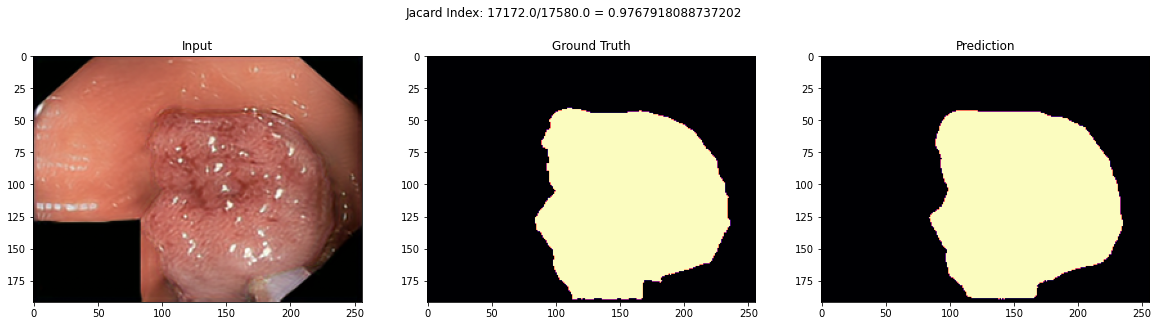

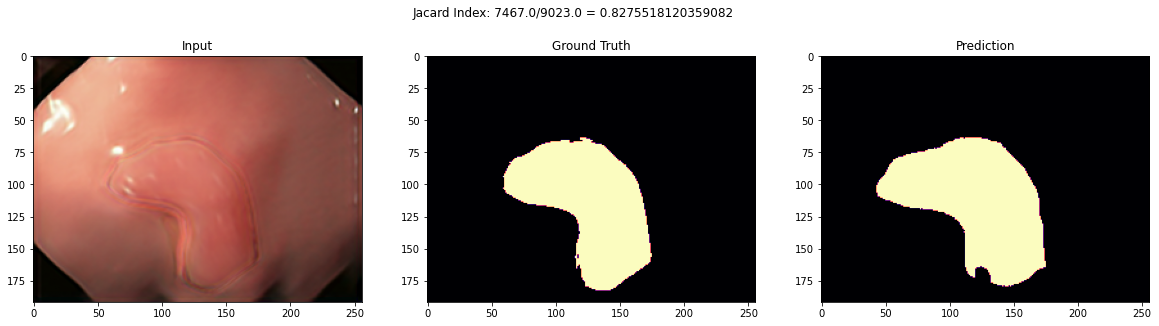

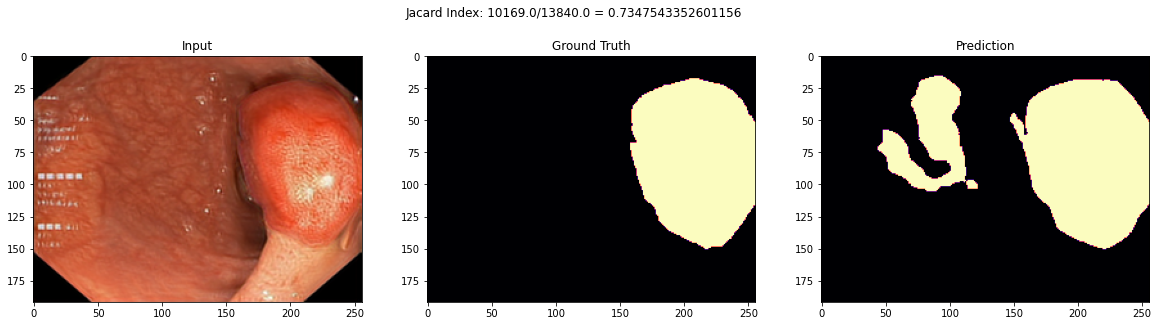

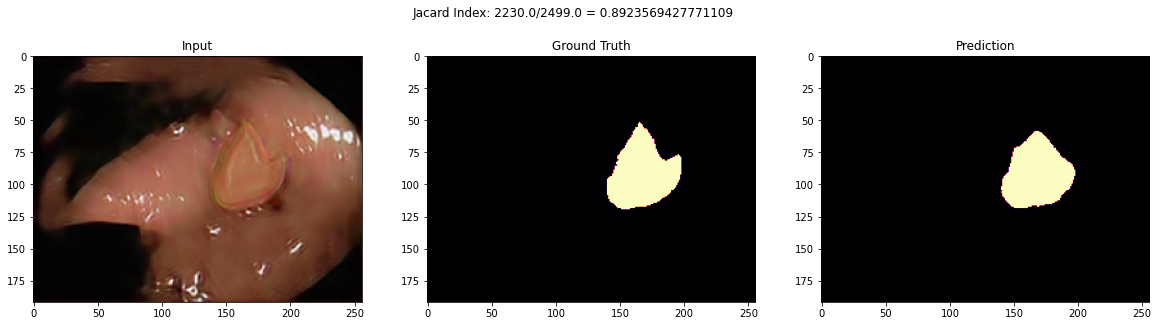

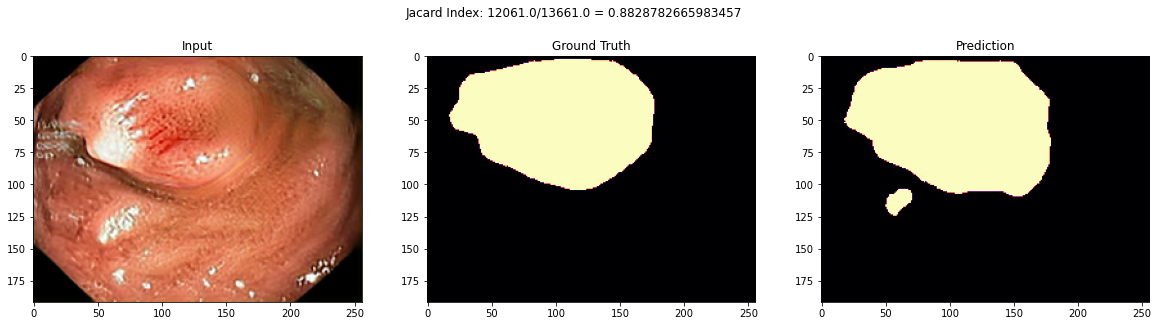

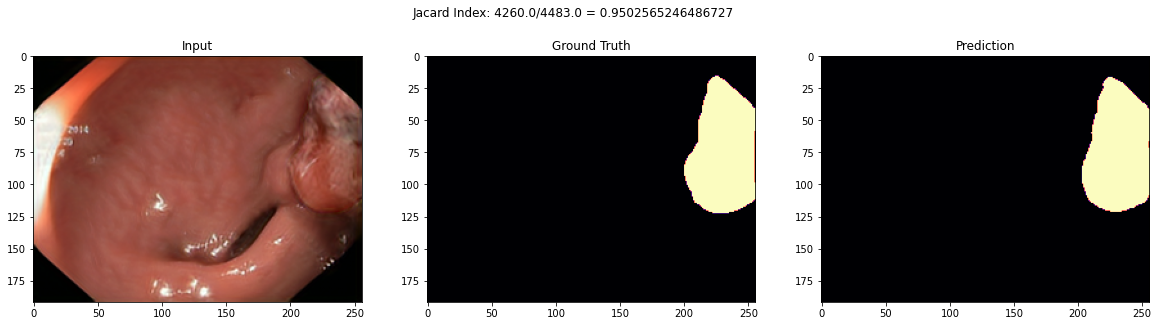

In [22]:
os.makedirs('densenet_unet_res', exist_ok=True)
for i in range(6):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    if len(X_test[i].shape) >= 2:
        plt.grid(False)
        plt.imshow(X_test[i].squeeze(), cmap='gray')  # 1-channel image
    else:
        plt.grid(False)
        plt.imshow(X_test[i])  # 3-channel

    plt.title('Input')
    plt.subplot(1, 3, 2)
    plt.grid(False)
    plt.imshow(Y_test[i].reshape(Y_test[i].shape[0], Y_test[i].shape[1]), cmap='magma')  # cmap='magma'
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.grid(False)
    plt.imshow(yp[i].reshape(yp[i].shape[0], yp[i].shape[1]), cmap='magma')
    plt.title('Prediction')

    # Calc jaccard index of predictions
    intersection = yp[i].ravel() * Y_test[i].ravel()
    union = yp[i].ravel() + Y_test[i].ravel() - intersection
    jacard = (np.sum(intersection) / np.sum(union))

    plt.suptitle('Jacard Index: ' + str(np.sum(intersection)) + '/' + str(np.sum(union)) + ' = ' + str(jacard))
    plt.savefig(r"/home/weiweili/notebook/WHJ/params2/densenet_unet_res/test_%d.tif"%(i))
    plt.show()


In [23]:
X = np.array(X)
Y = np.array(Y)
Y = Y.reshape((Y.shape[0], Y.shape[1], Y.shape[2], 1))
X = X / 255
Y = Y / 255
Y = np.round(Y, 0)
X = exposure.adjust_gamma(X, 1.5)


In [24]:
kf = KFold(n_splits=5)
k=0

In [25]:
for train_index, test_index in kf.split(X):
    k+=1
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]

    def jacard(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
        return intersection / union

    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    model = SharpUNet((192, 256, 3), 1)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[jacard, dice_coef])
    
    epochs = 500
    his = model.fit(X_train, Y_train,
          batch_size=2,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr],
          shuffle=True)
    history = his.history
    df = pd.DataFrame(history)
    df.to_csv('/home/weiweili/notebook/WHJ/params2/1densenet_unet-histtory_%d.csv'% (k))
    yp = model.predict(x=X_test, batch_size=2, verbose=0)
    yp = np.round(yp, 0)
    jacard = 0
    dice = 0
    sen = 0
    pre = 0
    jsc = 0
    mmc = 0

    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()
        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection
        jacard += (np.sum(intersection) / np.sum(union))
        dice += (2. * np.sum(intersection)) / (np.sum(yp_2) + np.sum(y2))
        TP = np.sum(yp_2 * y2)
        TN = np.sum((1 - yp_2) * (1 - y2))
        FP = np.sum(yp_2 * (1 - y2))
        FN = np.sum(y2 * (1 - yp_2))
        sen += TP / (TP + FN)
        pre += TP / (TP + FP)
        jsc += TP / (TP + FN + FP)
        mmc += (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    jacard /= len(Y_test)
    dice /= len(Y_test)
    sen /= len(Y_test)
    pre /= len(Y_test)
    jsc /= len(Y_test)
    mmc /= len(Y_test)

    print("%d-th fold verification:" % (k))
    print('Jacard Index : ' + str(jacard))
    print('Dice Coefficient : ' + str(dice))
    print('sen : ' + str(sen))
    print('pre : ' + str(pre))
    print('jsc : ' + str(jsc))
    print('mmc : ' + str(mmc))

print('ok')


Epoch 1/500
35/35 [==============================] - 1s 40ms/step - loss: 0.4437 - jacard: 0.1568 - dice_coef: 0.2667 - val_loss: 0.6115 - val_jacard: 0.1727 - val_dice_coef: 0.2943
Epoch 2/500
35/35 [==============================] - 1s 24ms/step - loss: 0.3528 - jacard: 0.2178 - dice_coef: 0.3543 - val_loss: 0.9928 - val_jacard: 0.0416 - val_dice_coef: 0.0793
Epoch 3/500
35/35 [==============================] - 1s 24ms/step - loss: 0.3242 - jacard: 0.2721 - dice_coef: 0.4185 - val_loss: 0.5971 - val_jacard: 0.1421 - val_dice_coef: 0.2486
Epoch 4/500
35/35 [==============================] - 1s 25ms/step - loss: 0.2977 - jacard: 0.3079 - dice_coef: 0.4625 - val_loss: 0.6929 - val_jacard: 0.1048 - val_dice_coef: 0.1890
Epoch 5/500
35/35 [==============================] - 1s 25ms/step - loss: 0.2795 - jacard: 0.3466 - dice_coef: 0.5022 - val_loss: 0.7112 - val_jacard: 0.0906 - val_dice_coef: 0.1659
Epoch 6/500
35/35 [==============================] - 1s 26ms/step - loss: 0.2252 - jacard:

Epoch 45/500
35/35 [==============================] - 1s 26ms/step - loss: 0.0279 - jacard: 0.8939 - dice_coef: 0.9433 - val_loss: 0.2150 - val_jacard: 0.7796 - val_dice_coef: 0.8718
Epoch 46/500
35/35 [==============================] - 1s 26ms/step - loss: 0.0257 - jacard: 0.9026 - dice_coef: 0.9483 - val_loss: 0.1566 - val_jacard: 0.8200 - val_dice_coef: 0.8999
Epoch 47/500
35/35 [==============================] - 1s 25ms/step - loss: 0.0254 - jacard: 0.9057 - dice_coef: 0.9500 - val_loss: 0.1964 - val_jacard: 0.8206 - val_dice_coef: 0.9003
Epoch 48/500
35/35 [==============================] - 1s 27ms/step - loss: 0.0239 - jacard: 0.9138 - dice_coef: 0.9546 - val_loss: 0.1813 - val_jacard: 0.8182 - val_dice_coef: 0.8989
Epoch 49/500
35/35 [==============================] - 1s 26ms/step - loss: 0.0232 - jacard: 0.9107 - dice_coef: 0.9526 - val_loss: 0.2237 - val_jacard: 0.7831 - val_dice_coef: 0.8740
Epoch 50/500
35/35 [==============================] - ETA: 0s - loss: 0.0214 - jacard

Epoch 86/500
35/35 [==============================] - 1s 25ms/step - loss: 0.0212 - jacard: 0.9169 - dice_coef: 0.9562 - val_loss: 0.1928 - val_jacard: 0.8211 - val_dice_coef: 0.9005
Epoch 87/500
35/35 [==============================] - 1s 25ms/step - loss: 0.0200 - jacard: 0.9206 - dice_coef: 0.9583 - val_loss: 0.1950 - val_jacard: 0.8210 - val_dice_coef: 0.9004
Epoch 88/500
35/35 [==============================] - 1s 25ms/step - loss: 0.0203 - jacard: 0.9249 - dice_coef: 0.9607 - val_loss: 0.1924 - val_jacard: 0.8215 - val_dice_coef: 0.9007
Epoch 89/500
35/35 [==============================] - 1s 26ms/step - loss: 0.0200 - jacard: 0.9176 - dice_coef: 0.9566 - val_loss: 0.1954 - val_jacard: 0.8203 - val_dice_coef: 0.9000
Epoch 90/500
34/35 [============================>.] - ETA: 0s - loss: 0.0209 - jacard: 0.9243 - dice_coef: 0.9604
Epoch 00090: ReduceLROnPlateau reducing learning rate to 1e-08.
35/35 [==============================] - 1s 25ms/step - loss: 0.0213 - jacard: 0.9224 - di

KeyboardInterrupt: 